Stock Prediction Model with N225 - 3 Year

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import plot

#for offline plotting
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [2]:
# Loading N225 Index historical pricing from research paper 10/5/18 to 10/4/21
VTI = pd.read_csv('N225_Original_Sample.csv')
VTI.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,10/5/2018,23781.75977,23928.61914,23730.18945,23783.72070,23783.72070,84600000.0
1,10/8/2018,NaN,NaN,NaN,NaN,NaN,NaN
2,10/9/2018,23550.47070,23587.05078,23442.46094,23469.39063,23469.39063,86500000.0
3,10/10/2018,23538.91992,23589.38086,23373.53906,23506.03906,23506.03906,70600000.0
4,10/11/2018,23043.36914,23051.18945,22459.01953,22590.85938,22590.85938,115300000.0


In [3]:
#overview of the data
VTI.info()
VTI.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729 entries, 0 to 728
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       729 non-null    object 
 1   Open       725 non-null    float64
 2   High       725 non-null    float64
 3   Low        725 non-null    float64
 4   Close      725 non-null    float64
 5   Adj Close  725 non-null    float64
 6   Volume     725 non-null    float64
dtypes: float64(6), object(1)
memory usage: 40.0+ KB


,Open,High,Low,Close,Adj Close,Volume
count,725.000000,725.000000,725.000000,725.000000,725.000000,7.250000e+02
mean,23853.377958,23978.852606,23716.477805,23853.563287,23853.563287,7.150524e+07
std,3318.661549,3324.782494,3318.931618,3317.312274,3317.312274,2.346534e+07
min,16570.570310,17049.029300,16358.190430,16552.830080,16552.830080,0.000000e+00
25%,21422.220700,21522.750000,21308.880860,21425.509770,21425.509770,5.720000e+07
50%,22885.140630,22961.230470,22765.580080,22867.269530,22867.269530,6.780000e+07
75%,27238.449220,27541.630860,27073.460940,27281.169920,27281.169920,8.050000e+07
max,30606.150390,30795.779300,30504.810550,30670.099610,30670.099610,2.334000e+08


In [4]:
#date range of the data
VTI['Date'] = pd.to_datetime(VTI['Date'])
print(f'Dataframe contains stock prices between {VTI.Date.min()} {VTI.Date.max()}') 
print(f'Total days = {(VTI.Date.max()  - VTI.Date.min()).days} days')

Dataframe contains stock prices between 2018-10-05 00:00:00 2021-10-04 00:00:00
Total days = 1095 days


In [5]:
# Plotting Historical performance of the ETF
layout = go.Layout(
    title='N225 Index Price',
    xaxis=dict(
        title='Date',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='Japanese Yen',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    )
)

VTI_data = [{'x':VTI['Date'], 'y':VTI['Close']}]
plot = go.Figure(data=VTI_data, layout=layout)


iplot(plot)

In [6]:
# Building the regression model
from sklearn.model_selection import train_test_split

#For preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

#For model evaluation
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mape

In [7]:
#Split the data into train and test sets
VTI = VTI.dropna()
X = np.array(VTI.index).reshape(-1,1)
Y = VTI['Adj Close']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=101)

In [8]:
# Feature scaling
scaler = StandardScaler().fit(X_train)

In [9]:
# First Model - Linear Regression
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_train, Y_train)

#Plot actual and predicted values for train dataset
trace0 = go.Scatter(
    x = X_train.T[0],
    y = Y_train,
    mode = 'markers',
    name = 'Actual'
)
trace1 = go.Scatter(
    x = X_train.T[0],
    y = lm.predict(X_train).T,
    mode = 'lines',
    name = 'Predicted'
)
VTI_data = [trace0,trace1]
layout.xaxis.title.text = 'Day'
plot2 = go.Figure(data=VTI_data, layout=layout)

iplot(plot2)

In [10]:
#Calculate scores for model evaluation
import math 
scores = f'''
{'Metric'.ljust(10)}{'Train'.center(20)}{'Test'.center(20)}
{'RMSE'.ljust(10)}{np.sqrt(mse(Y_train, lm.predict(X_train)))}\t{np.sqrt(mse(Y_test, lm.predict(X_test)))}
{'MAPE'.ljust(10)}{mape(Y_train, lm.predict(X_train))}\t{mape(Y_test, lm.predict(X_test))}
'''
print(scores)


Metric           Train                Test        
RMSE      2013.395006866114	1888.72358807243
MAPE      0.06733762785298442	0.0627775683907913



In [11]:
# Second Model - Logistic Regression
from sklearn.linear_model import LogisticRegression

#To avoid "continuous" error for Logistic Regression and KNN, convert data
from sklearn import preprocessing
from sklearn import utils
lab_enc = preprocessing.LabelEncoder()
training_scores_encoded = lab_enc.fit_transform(Y_train)

clf = LogisticRegression()
clf.fit(X_train, training_scores_encoded)


#Plot actual and predicted values for train dataset
trace0 = go.Scatter(
    x = X_train.T[0],
    y = Y_train,
    mode = 'markers',
    name = 'Actual'
)
trace1 = go.Scatter(
    x = X_train.T[0],
    y = clf.predict(X_train).T,
    mode = 'markers',
    name = 'Predicted'
)
VTI_data = [trace0,trace1]
layout.xaxis.title.text = 'Day'
plot2 = go.Figure(data=VTI_data, layout=layout)

iplot(plot2)




C:\Users\vince\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [12]:
#Calculate scores for model evaluation
import math 
scores = f'''
{'Metric'.ljust(10)}{'Train'.center(20)}{'Test'.center(20)}
{'RMSE'.ljust(10)}{np.sqrt(mse(Y_train, clf.predict(X_train)))}\t{np.sqrt(mse(Y_test, clf.predict(X_test)))}
{'MAPE'.ljust(10)}{mape(Y_train, clf.predict(X_train))}\t{mape(Y_test, clf.predict(X_test))}
'''
print(scores)




Metric           Train                Test        
RMSE      23650.42207286303	23545.114560872953
MAPE      0.9811860995730216	0.9811599877604239



In [13]:
# Third Modal - KNN
from sklearn import datasets
from sklearn.preprocessing import StandardScaler, scale
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, classification_report
#%%time

#warnings.filterwarnings('ignore')

# The param_grid tells Scikit-Learn to evaluate all combinations of the hyperparameter values
param_grid = {'n_neighbors': np.arange(1,50), 'p': [1, 2, 10, 50, 100, 500, 1000], 
              'weights': ["uniform", "distance"]}

knn_clf = KNeighborsClassifier()

knn_cv = GridSearchCV(knn_clf, param_grid, scoring='f1', cv=2, verbose=3, n_jobs=-1)
knn_cv.fit(X_train, training_scores_encoded)


params_optimal_knn = knn_cv.best_params_

knn = KNeighborsClassifier(**params_optimal_knn)

knn.fit(X_train, training_scores_encoded)

y_train_predicted = knn.predict(X_train)

#Plot actual and predicted values for train dataset
trace0 = go.Scatter(
    x = X_train.T[0],
    y = Y_train,
    mode = 'markers',
    name = 'Actual'
)
trace1 = go.Scatter(
    x = X_train.T[0],
    y = knn.predict(X_train).T,
    mode = 'markers',
    name = 'Predicted'
)
VTI_data = [trace0,trace1]
layout.xaxis.title.text = 'Day'
plot2 = go.Figure(data=VTI_data, layout=layout)

iplot(plot2)



Fitting 2 folds for each of 686 candidates, totalling 1372 fits


ValueError: n_splits=2 cannot be greater than the number of members in each class.

In [14]:
#Calculate scores for model evaluation
import math 
scores = f'''
{'Metric'.ljust(10)}{'Train'.center(20)}{'Test'.center(20)}
{'RMSE'.ljust(10)}{np.sqrt(mse(Y_train, knn.predict(X_train)))}\t{np.sqrt(mse(Y_test, knn.predict(X_test)))}
{'MAPE'.ljust(10)}{mape(Y_train, knn.predict(X_train))}\t{mape(Y_test, knn.predict(X_test))}
'''
print(scores)

NameError: name 'knn' is not defined

In [15]:
# Fourth Model - Gaussian NB

#%%time

#warnings.filterwarnings('ignore')
from sklearn.naive_bayes import GaussianNB, MultinomialNB
param_grid = {'var_smoothing': [0.001, 0.01, 0.1, 1.0]}

gnb = GaussianNB()

gnb = GridSearchCV(gnb, param_grid, scoring='accuracy', cv=2, verbose=1, n_jobs=-1)
gnb.fit(X_train, training_scores_encoded)

params_optimal = gnb.best_params_

gaussianNB_clf = GaussianNB(**params_optimal)

gaussianNB_clf.fit(X_train, training_scores_encoded) 

y_test_predicted = gaussianNB_clf.predict(X_test)

#Plot actual and predicted values for train dataset
trace0 = go.Scatter(
    x = X_train.T[0],
    y = Y_train,
    mode = 'markers',
    name = 'Actual'
)
trace1 = go.Scatter(
    x = X_train.T[0],
    y = gaussianNB_clf.predict(X_train).T,
    mode = 'markers',
    name = 'Predicted'
)
VTI_data = [trace0,trace1]
layout.xaxis.title.text = 'Day'
plot2 = go.Figure(data=VTI_data, layout=layout)

iplot(plot2)

Fitting 2 folds for each of 4 candidates, totalling 8 fits


ValueError: n_splits=2 cannot be greater than the number of members in each class.

In [16]:
#Calculate scores for model evaluation
import math 
scores = f'''
{'Metric'.ljust(10)}{'Train'.center(20)}{'Test'.center(20)}
{'RMSE'.ljust(10)}{np.sqrt(mse(Y_train, gaussianNB_clf.predict(X_train)))}\t{np.sqrt(mse(Y_test, gaussianNB_clf.predict(X_test)))}
{'MAPE'.ljust(10)}{mape(Y_train, gaussianNB_clf.predict(X_train))}\t{mape(Y_test, gaussianNB_clf.predict(X_test))}
'''
print(scores)

NameError: name 'gaussianNB_clf' is not defined

In [17]:
#5th Model LSTM

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout

data = pd.read_csv('N225_Original_Sample.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,10/5/2018,23781.75977,23928.61914,23730.18945,23783.72070,23783.72070,84600000.0
1,10/8/2018,NaN,NaN,NaN,NaN,NaN,NaN
2,10/9/2018,23550.47070,23587.05078,23442.46094,23469.39063,23469.39063,86500000.0
3,10/10/2018,23538.91992,23589.38086,23373.53906,23506.03906,23506.03906,70600000.0
4,10/11/2018,23043.36914,23051.18945,22459.01953,22590.85938,22590.85938,115300000.0


In [18]:
data["Adj Close"]=pd.to_numeric(data.Close,errors='coerce')
data = data.dropna()
trainData = data.iloc[:,4:5].values
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 725 entries, 0 to 728
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       725 non-null    object 
 1   Open       725 non-null    float64
 2   High       725 non-null    float64
 3   Low        725 non-null    float64
 4   Close      725 non-null    float64
 5   Adj Close  725 non-null    float64
 6   Volume     725 non-null    float64
dtypes: float64(6), object(1)
memory usage: 45.3+ KB


In [19]:
sc = MinMaxScaler(feature_range=(0,1))
trainData = sc.fit_transform(trainData)
trainData.shape

(725, 1)

In [20]:
X_train = []
y_train = []

for i in range (60,725): #60 : timestep // 604 : length of the data
    X_train.append(trainData[i-60:i,0]) 
    y_train.append(trainData[i,0])

X_train,y_train = np.array(X_train),np.array(y_train)

In [21]:
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1)) #adding the batch_size axis
X_train.shape

(665, 60, 1)

In [22]:
model = Sequential()

model.add(LSTM(units=100, return_sequences = True, input_shape =(X_train.shape[1],1)))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences = False))
model.add(Dropout(0.2))

model.add(Dense(units =1))
model.compile(optimizer='adam',loss="mean_squared_error")

In [23]:
hist = model.fit(X_train, y_train, epochs = 20, batch_size = 32, verbose=2)

Epoch 1/20
21/21 - 10s - loss: 0.0592 - 10s/epoch - 475ms/step
Epoch 2/20
21/21 - 5s - loss: 0.0118 - 5s/epoch - 236ms/step
Epoch 3/20
21/21 - 5s - loss: 0.0071 - 5s/epoch - 229ms/step
Epoch 4/20
21/21 - 5s - loss: 0.0063 - 5s/epoch - 234ms/step
Epoch 5/20
21/21 - 5s - loss: 0.0074 - 5s/epoch - 215ms/step
Epoch 6/20
21/21 - 5s - loss: 0.0070 - 5s/epoch - 228ms/step
Epoch 7/20
21/21 - 5s - loss: 0.0054 - 5s/epoch - 228ms/step
Epoch 8/20
21/21 - 4s - loss: 0.0050 - 4s/epoch - 210ms/step
Epoch 9/20
21/21 - 5s - loss: 0.0050 - 5s/epoch - 229ms/step
Epoch 10/20
21/21 - 5s - loss: 0.0054 - 5s/epoch - 233ms/step
Epoch 11/20
21/21 - 5s - loss: 0.0055 - 5s/epoch - 227ms/step
Epoch 12/20
21/21 - 4s - loss: 0.0044 - 4s/epoch - 206ms/step
Epoch 13/20
21/21 - 5s - loss: 0.0051 - 5s/epoch - 229ms/step
Epoch 14/20
21/21 - 5s - loss: 0.0047 - 5s/epoch - 225ms/step
Epoch 15/20
21/21 - 4s - loss: 0.0046 - 4s/epoch - 197ms/step
Epoch 16/20
21/21 - 4s - loss: 0.0051 - 4s/epoch - 198ms/step
Epoch 17/20
21/

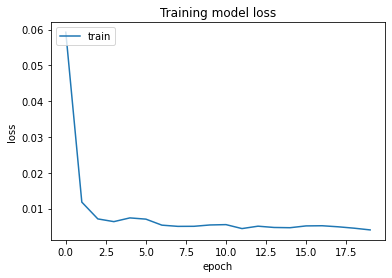

In [24]:
plt.plot(hist.history['loss'])
plt.title('Training model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [25]:
testData = pd.read_csv('N225_Test_Data.csv')
testData["Close"]=pd.to_numeric(testData.Close,errors='coerce')
testData = testData.dropna()
testData = testData.iloc[:,4:5]
y_test = testData.iloc[60:,0:].values 
#input array for the model
inputClosing = testData.iloc[:,0:].values 
inputClosing_scaled = sc.transform(inputClosing)
inputClosing_scaled.shape
X_test = []
length = len(testData)
timestep = 60
for i in range(timestep,length):  
    X_test.append(inputClosing_scaled[i-timestep:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
X_test.shape

(84, 60, 1)

In [26]:
y_pred = model.predict(X_test)
y_pred

3/3 [==============================] - 1s 26ms/step


array([[0.8809657 ],
       [0.882942  ],
       [0.8856363 ],
       [0.8892864 ],
       [0.8928608 ],
       [0.89528626],
       [0.8955641 ],
       [0.8938939 ],
       [0.8905848 ],
       [0.8856726 ],
       [0.8796004 ],
       [0.8728744 ],
       [0.8650942 ],
       [0.85635996],
       [0.8467797 ],
       [0.83675957],
       [0.826322  ],
       [0.81546915],
       [0.8034314 ],
       [0.79043627],
       [0.7775084 ],
       [0.76587427],
       [0.75704443],
       [0.75169045],
       [0.75006115],
       [0.75166637],
       [0.755692  ],
       [0.7615494 ],
       [0.768772  ],
       [0.7761113 ],
       [0.7821392 ],
       [0.78655154],
       [0.7892356 ],
       [0.79016834],
       [0.78925145],
       [0.7860372 ],
       [0.7798282 ],
       [0.77103347],
       [0.7606324 ],
       [0.7501325 ],
       [0.7403621 ],
       [0.7320154 ],
       [0.7248359 ],
       [0.71752894],
       [0.70856225],
       [0.69702893],
       [0.68397915],
       [0.670

In [27]:
predicted_price = sc.inverse_transform(y_pred)

In [28]:
y_pred1 = model.predict(X_train)
y_pred1

21/21 [==============================] - 2s 97ms/step


array([[0.2579922 ],
       [0.24649955],
       [0.23893808],
       [0.23546769],
       [0.23586114],
       [0.23971549],
       [0.24626468],
       [0.25450736],
       [0.2636791 ],
       [0.27317628],
       [0.28237438],
       [0.29069299],
       [0.29767156],
       [0.30322546],
       [0.30732507],
       [0.31003094],
       [0.3113724 ],
       [0.31165576],
       [0.31127036],
       [0.31066418],
       [0.31014675],
       [0.30991775],
       [0.30992937],
       [0.30962908],
       [0.30901945],
       [0.30859244],
       [0.3088404 ],
       [0.30981773],
       [0.31172973],
       [0.31468874],
       [0.31875086],
       [0.3238253 ],
       [0.3296106 ],
       [0.33579236],
       [0.34194523],
       [0.34776163],
       [0.35283208],
       [0.35704917],
       [0.36066568],
       [0.36387116],
       [0.3666327 ],
       [0.36870748],
       [0.36943883],
       [0.3684395 ],
       [0.3660562 ],
       [0.3626938 ],
       [0.35878015],
       [0.354

In [29]:
predicted_price1 = sc.inverse_transform(y_pred1)
actual_price = sc.inverse_transform(y_train.reshape(-1, 1))

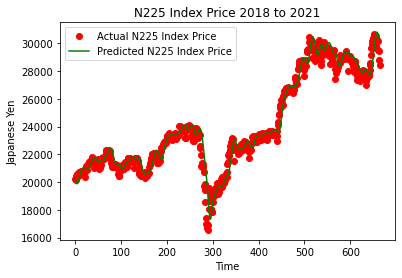

In [30]:
plt.plot(actual_price, 'o' , color = 'red', label = 'Actual N225 Index Price')
plt.plot(predicted_price1, color = 'green', label = 'Predicted N225 Index Price')
plt.title('N225 Index Price 2018 to 2021')
plt.xlabel('Time')
plt.ylabel('Japanese Yen')
plt.legend()
plt.show()

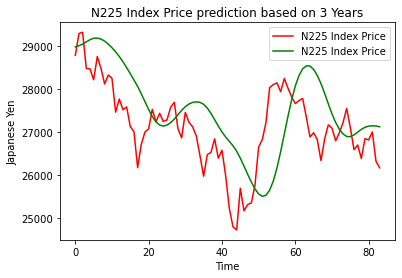

In [31]:
plt.plot(y_test, color = 'red', label = 'N225 Index Price')
plt.plot(predicted_price, color = 'green', label = 'N225 Index Price')
plt.title('N225 Index Price prediction based on 3 Years')
plt.xlabel('Time')
plt.ylabel('Japanese Yen')
plt.legend()
plt.show()

In [32]:
#Calculate scores for model evaluation
import math 
scores = f'''
{'Metric'.ljust(10)}{'Train'.center(20)}{'Test'.center(20)}
{'RMSE'.ljust(10)}{np.sqrt(mse(actual_price, predicted_price1))}\t{np.sqrt(mse(y_test, predicted_price))}
{'MAPE'.ljust(10)}{mape(actual_price, predicted_price1)}\t{mape(y_test, predicted_price)}
'''
print(scores)


Metric           Train                Test        
RMSE      679.889400705002	991.1657274833575
MAPE      0.02001360071249168	0.030317285346156325

